In [1]:
########################################################################
###################### Carga de módulos ################################
########################################################################

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from google.colab import drive, files
import zipfile
import os
import shutil
import matplotlib.pyplot as plt
import time

In [4]:
# === Rutas de entrada y salida ===
origen = "/content/drive/MyDrive/animales"
ruta_preentrenamiento = "/content/drive/MyDrive/dataset_animales_dividido/preentrenamiento"
ruta_prueba = "/content/drive/MyDrive/dataset_animales_dividido/prueba"

# Crear carpetas destino si no existen
os.makedirs(ruta_preentrenamiento, exist_ok=True)
os.makedirs(ruta_prueba, exist_ok=True)

# Recorrer cada clase
for clase in sorted(os.listdir(origen)):
    ruta_clase = os.path.join(origen, clase)
    if not os.path.isdir(ruta_clase):
        continue

    imagenes = os.listdir(ruta_clase)
    rutas_imagenes = [os.path.join(ruta_clase, img) for img in imagenes]

    # Dividir en 80% preentrenamiento y 20% prueba
    preentrenamiento, prueba = train_test_split(rutas_imagenes, test_size=0.2, random_state=42)

    # Crear carpetas destino por clase
    os.makedirs(os.path.join(ruta_preentrenamiento, clase), exist_ok=True)
    os.makedirs(os.path.join(ruta_prueba, clase), exist_ok=True)

    # Copiar archivos
    for img in preentrenamiento:
        shutil.copy(img, os.path.join(ruta_preentrenamiento, clase))

    for img in prueba:
        shutil.copy(img, os.path.join(ruta_prueba, clase))

print("✅ Separación completada:")
print("80% → preentrenamiento")
print("20% → prueba")

✅ Separación completada:
80% → preentrenamiento
20% → prueba


In [5]:
########################################################################
###################### Parámetros generales ############################
########################################################################

img_height, img_width = 150, 150
batch_size = 32
epochs = 50
validation_split = 0.2

########################################################################
###################### Generadores de imágenes #########################
########################################################################

# Generador para preentrenamiento (con validación)
datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

train_generator = datagen.flow_from_directory(
    ruta_preentrenamiento,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

ruta_txt = "nombres_clases.txt"
with open(ruta_txt, "w") as f:
    for nombre in train_generator.class_indices:
        f.write(nombre + "\n")

# Descargarlo a tu computadora (opcional)
from google.colab import files
files.download(ruta_txt)

val_generator = datagen.flow_from_directory(
    ruta_preentrenamiento,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Generador para prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    ruta_prueba,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Clases
num_classes = len(train_generator.class_indices)
print("Clases detectadas:", train_generator.class_indices)


Found 16742 images belonging to 10 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 4181 images belonging to 10 classes.
Found 5236 images belonging to 10 classes.
Clases detectadas: {'arana': 0, 'ardilla': 1, 'caballo': 2, 'elefante': 3, 'gallina': 4, 'gato': 5, 'mariposa': 6, 'oveja': 7, 'perro': 8, 'vaca': 9}


In [6]:
########################################################################
###################### Modelo y compilación ############################
########################################################################

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

########################################################################
###################### Entrenamiento del modelo ########################
########################################################################

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor='val_accuracy',
                             save_best_only=True, verbose=1)

inicio = time.time()
historial = model.fit(train_generator,
                      validation_data=val_generator,
                      epochs=epochs,
                      callbacks=[early_stop, checkpoint])
fin = time.time()
duracion = fin - inicio
print(f"🕒 Entrenamiento completado en {duracion/60:.2f} minutos.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2235 - loss: 2.1598
Epoch 1: val_accuracy improved from -inf to 0.35518, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 113s 204ms/step - accuracy: 0.2236 - loss: 2.1596 - val_accuracy: 0.3552 - val_loss: 1.8629
Epoch 2/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3417 - loss: 1.8755
Epoch 2: val_accuracy improved from 0.35518 to 0.39536, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 88s 167ms/step - accuracy: 0.3418 - loss: 1.8754 - val_accuracy: 0.3954 - val_loss: 1.7355
Epoch 3/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3907 - loss: 1.7462
Epoch 3: val_accuracy improved from 0.39536 to 0.45109, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 91s 173ms/step - accuracy: 0.3907 - loss: 1.7462 - val_accuracy: 0.4511 - val_loss: 1.6145
Epoch 4/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4282 - loss: 1.6575
Epoch 4: val_accuracy improved from 0.45109 to 0.45898, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 88s 167ms/step - accuracy: 0.4282 - loss: 1.6575 - val_accuracy: 0.4590 - val_loss: 1.5591
Epoch 5/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4495 - loss: 1.5750
Epoch 5: val_accuracy improved from 0.45898 to 0.48816, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 94s 179ms/step - accuracy: 0.4495 - loss: 1.5750 - val_accuracy: 0.4882 - val_loss: 1.5026
Epoch 6/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4795 - loss: 1.4994
Epoch 6: val_accuracy did not improve from 0.48816
524/524 ━━━━━━━━━━━━━━━━━━━━ 88s 167ms/step - accuracy: 0.4795 - loss: 1.4994 - val_accuracy: 0.4841 - val_loss: 1.4841
Epoch 7/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5061 - loss: 1.4146
Epoch 7: val_accuracy improved from 0.48816 to 0.51806, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 171ms/step - accuracy: 0.5061 - loss: 1.4147 - val_accuracy: 0.5181 - val_loss: 1.4133
Epoch 8/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5260 - loss: 1.3628
Epoch 8: val_accuracy improved from 0.51806 to 0.54030, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 172ms/step - accuracy: 0.5260 - loss: 1.3628 - val_accuracy: 0.5403 - val_loss: 1.3606
Epoch 9/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5424 - loss: 1.3013
Epoch 9: val_accuracy did not improve from 0.54030
524/524 ━━━━━━━━━━━━━━━━━━━━ 91s 174ms/step - accuracy: 0.5424 - loss: 1.3013 - val_accuracy: 0.5403 - val_loss: 1.3422
Epoch 10/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5623 - loss: 1.2591
Epoch 10: val_accuracy improved from 0.54030 to 0.54939, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 91s 174ms/step - accuracy: 0.5623 - loss: 1.2590 - val_accuracy: 0.5494 - val_loss: 1.3177
Epoch 11/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5821 - loss: 1.1860
Epoch 11: val_accuracy improved from 0.54939 to 0.55920, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 89s 170ms/step - accuracy: 0.5821 - loss: 1.1860 - val_accuracy: 0.5592 - val_loss: 1.3023
Epoch 12/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5978 - loss: 1.1425
Epoch 12: val_accuracy did not improve from 0.55920
524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 171ms/step - accuracy: 0.5978 - loss: 1.1425 - val_accuracy: 0.5448 - val_loss: 1.3342
Epoch 13/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6240 - loss: 1.0840
Epoch 13: val_accuracy improved from 0.55920 to 0.56159, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 88s 168ms/step - accuracy: 0.6240 - loss: 1.0840 - val_accuracy: 0.5616 - val_loss: 1.3095
Epoch 14/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6362 - loss: 1.0290
Epoch 14: val_accuracy did not improve from 0.56159
524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 172ms/step - accuracy: 0.6362 - loss: 1.0290 - val_accuracy: 0.5599 - val_loss: 1.3012
Epoch 15/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6596 - loss: 0.9768
Epoch 15: val_accuracy did not improve from 0.56159
524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 172ms/step - accuracy: 0.6596 - loss: 0.9769 - val_accuracy: 0.5585 - val_loss: 1.3019
Epoch 16/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6730 - loss: 0.9333
Epoch 16: val_accuracy improved from 0.56159 to 0.57474, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 89s 170ms/step - accuracy: 0.6730 - loss: 0.9333 - val_accuracy: 0.5747 - val_loss: 1.2948
Epoch 17/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6826 - loss: 0.8853
Epoch 17: val_accuracy did not improve from 0.57474
524/524 ━━━━━━━━━━━━━━━━━━━━ 86s 164ms/step - accuracy: 0.6826 - loss: 0.8853 - val_accuracy: 0.5680 - val_loss: 1.3064
Epoch 18/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7019 - loss: 0.8469
Epoch 18: val_accuracy did not improve from 0.57474
524/524 ━━━━━━━━━━━━━━━━━━━━ 86s 164ms/step - accuracy: 0.7019 - loss: 0.8469 - val_accuracy: 0.5702 - val_loss: 1.3233
Epoch 19/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7184 - loss: 0.7946
Epoch 19: val_accuracy improved from 0.57474 to 0.57737, saving model to mejor_modelo.h5


524/524 ━━━━━━━━━━━━━━━━━━━━ 86s 165ms/step - accuracy: 0.7184 - loss: 0.7946 - val_accuracy: 0.5774 - val_loss: 1.3261
Epoch 20/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7336 - loss: 0.7640
Epoch 20: val_accuracy did not improve from 0.57737
524/524 ━━━━━━━━━━━━━━━━━━━━ 85s 162ms/step - accuracy: 0.7336 - loss: 0.7640 - val_accuracy: 0.5695 - val_loss: 1.3579
Epoch 21/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7430 - loss: 0.7185
Epoch 21: val_accuracy did not improve from 0.57737
524/524 ━━━━━━━━━━━━━━━━━━━━ 87s 166ms/step - accuracy: 0.7430 - loss: 0.7185 - val_accuracy: 0.5731 - val_loss: 1.3595
Epoch 22/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7571 - loss: 0.6844
Epoch 22: val_accuracy did not improve from 0.57737
524/524 ━━━━━━━━━━━━━━━━━━━━ 86s 163ms/step - accuracy: 0.7571 - loss: 0.6845 - val_accuracy: 0.5745 - val_loss: 1.3865
🕒 Entrenamiento completado en 32.96 minutos.


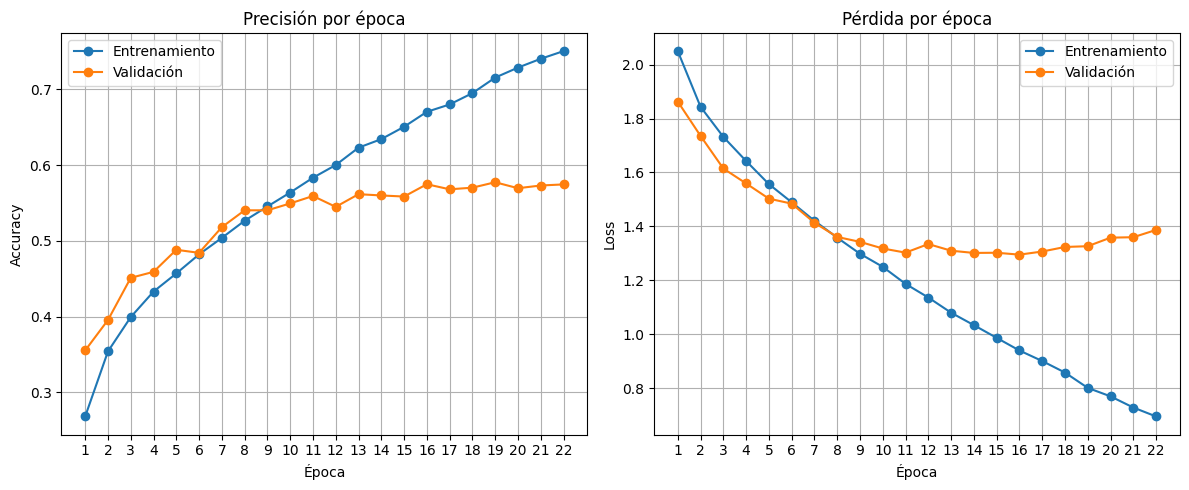

In [7]:
def graficar_metricas_entrenamiento(historial):
    epocas = range(1, len(historial.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epocas, historial.history['accuracy'], label='Entrenamiento', marker='o')
    plt.plot(epocas, historial.history['val_accuracy'], label='Validación', marker='o')
    plt.title('Precisión por época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.xticks(epocas)  # Mostrar todas las épocas enteras
    plt.legend()
    plt.grid(True)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epocas, historial.history['loss'], label='Entrenamiento', marker='o')
    plt.plot(epocas, historial.history['val_loss'], label='Validación', marker='o')
    plt.title('Pérdida por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.xticks(epocas)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamada
graficar_metricas_entrenamiento(historial)

In [8]:
########################################################################
###################### Evaluación en prueba ############################
########################################################################

mejor_val_acc = max(historial.history['val_accuracy'])
mejor_epoch = historial.history['val_accuracy'].index(mejor_val_acc) + 1
print(f"📈 Mejor precisión en validación: {mejor_val_acc:.4f} (época {mejor_epoch})")

📈 Mejor precisión en validación: 0.5774 (época 19)


In [10]:
########################################################################
#################### Carga de módulos ##################################
########################################################################

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import drive, files
import zipfile
import os
import numpy as np
import pandas as pd

########################################################################
#################### Cargar modelo y nombres de clase ##################
########################################################################

modelo = load_model("mejor_modelo.h5")

with open("/content/nombres_clases.txt", "r") as f:
    clases = [line.strip() for line in f]

diccionario_indices = {i: nombre for i, nombre in enumerate(clases)}

########################################################################
#################### Predicción sobre nuevas imágenes ##################
########################################################################

ruta_imagenes = "/content/drive/MyDrive/animales_desconocidos"
tamaño = (150, 150)

resultados = []

for archivo in sorted(os.listdir(ruta_imagenes)):
    ruta_completa = os.path.join(ruta_imagenes, archivo)
    if not archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img = image.load_img(ruta_completa, target_size=tamaño)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = modelo.predict(img_array, verbose=0)
    clase_predicha = np.argmax(pred)
    nombre_clase = diccionario_indices[clase_predicha]
    confianza = pred[0][clase_predicha]

    resultados.append({
        "archivo": archivo,
        "clase_predicha": nombre_clase,
        "confianza": f"{confianza:.2%}"
    })

########################################################################
#################### Guardar y mostrar resultados ######################
########################################################################

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

df_resultados.to_csv("predicciones_animales_desconocidos.csv", index=False)
files.download("predicciones_animales_desconocidos.csv")

            archivo clase_predicha confianza
0      arana_1.jpeg          arana    74.30%
1       arana_2.jpg          arana    57.81%
2    ardilla_1.jpeg          arana    85.95%
3    ardilla_2.jpeg       mariposa    44.40%
4    borrego_1.jpeg          oveja    21.67%
5    borrego_2.jpeg          oveja    60.37%
6    caballo_1.jpeg        caballo    59.27%
7    caballo_2.jpeg           vaca    28.78%
8       cane_1.jpeg          perro    68.62%
9       cane_2.jpeg        ardilla    28.17%
10  elefante_1.jpeg        gallina    44.47%
11  elefante_2.jpeg       elefante    79.67%
12   gallina_1.jpeg        gallina    53.37%
13   gallina_2.jpeg          perro    42.90%
14      gato_1.jpeg           gato    51.68%
15      gato_2.jpeg          arana    38.09%
16  mariposa_1.jpeg       mariposa    54.15%
17  mariposa_2.jpeg          arana    25.15%
18      vaca_1.jpeg           vaca    69.39%
19      vaca_2.jpeg          oveja    67.13%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>